In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

In [ ]:
BATCH_SIZE = 64
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


100%|██████████| 169M/169M [00:04<00:00, 41.7MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from torchvision.models import vgg11, VGG11_Weights
import torch.nn as nn

model = vgg11(weights=VGG11_Weights.IMAGENET1K_V1)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 112)
model = model.to(DEVICE)

print("Model architecture modified for CIFAR-100:")
print(model.classifier)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


100%|██████████| 507M/507M [00:07<00:00, 74.8MB/s]


Model architecture modified for CIFAR-100:
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=112, bias=True)
)


In [ ]:
cd gdrive/MyDrive

/content/gdrive/MyDrive


<>:35: SyntaxWarning: invalid escape sequence '\%'
<>:35: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipython-input-916965576.py:35: SyntaxWarning: invalid escape sequence '\%'
  ax.set_ylabel('Top-1 Accuracy (\%)', fontsize=12)


Plot saved successfully as 'scaling_law_plot.png'


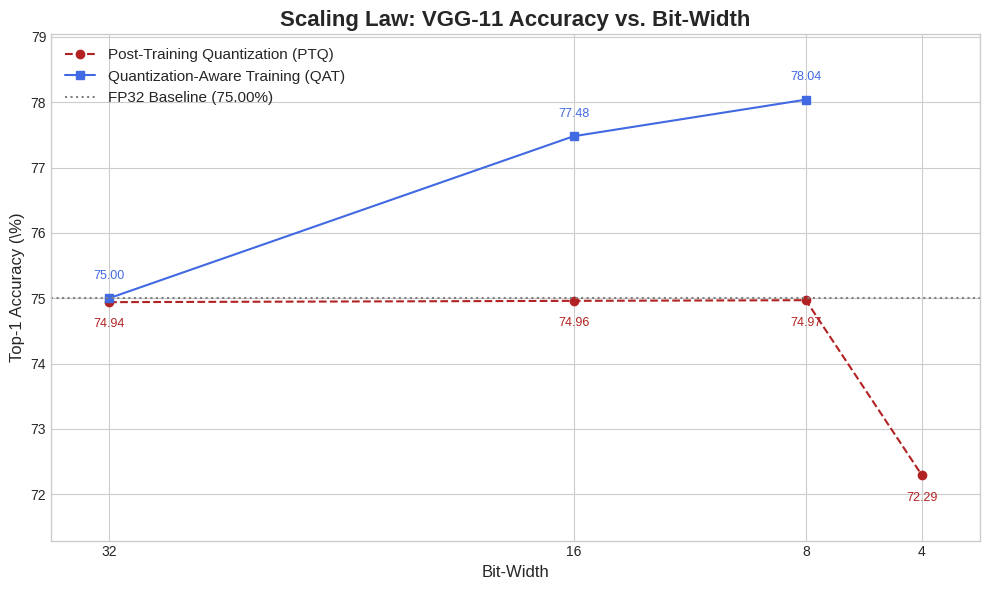

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


ptq_data = {
    'bits': [32, 16, 8, 4],
    'accuracy': [74.94, 74.96, 74.97, 72.29],
    'label': 'Post-Training Quantization (PTQ)'
}


qat_data = {
   
    'bits': [32, 16, 8],
    'accuracy': [75.00, 77.48, 78.04],
    'label': 'Quantization-Aware Training (QAT)'
}


plt.style.use('seaborn-v0_8-whitegrid') 
fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(ptq_data['bits'], ptq_data['accuracy'], marker='o', linestyle='--', color='firebrick', label=ptq_data['label'])


ax.plot(qat_data['bits'], qat_data['accuracy'], marker='s', linestyle='-', color='royalblue', label=qat_data['label'])


ax.set_title('Scaling Law: VGG-11 Accuracy vs. Bit-Width', fontsize=16, fontweight='bold')
ax.set_xlabel('Bit-Width', fontsize=12)
ax.set_ylabel('Top-1 Accuracy (\%)', fontsize=12)


ax.set_xticks(sorted(list(set(ptq_data['bits'] + qat_data['bits']))))
ax.set_xlim(left=34, right=2)


min_acc = min(ptq_data['accuracy'] + qat_data['accuracy'])
max_acc = max(ptq_data['accuracy'] + qat_data['accuracy'])
ax.set_ylim(bottom=min_acc - 1, top=max_acc + 1)


ax.legend(fontsize=11)


ax.axhline(y=75.00, color='gray', linestyle=':', linewidth=1.5, label='FP32 Baseline (75.00%)')

ax.legend(fontsize=11)


for i, acc in enumerate(ptq_data['accuracy']):
    ax.text(ptq_data['bits'][i], acc - 0.25, f'{acc:.2f}', ha='center', va='top', fontsize=9, color='firebrick')
for i, acc in enumerate(qat_data['accuracy']):
    ax.text(qat_data['bits'][i], acc + 0.25, f'{acc:.2f}', ha='center', va='bottom', fontsize=9, color='royalblue')


plt.tight_layout()


output_filename = 'scaling_law_plot.png'
plt.savefig(output_filename, dpi=300)

print(f"Plot saved successfully as '{output_filename}'")

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
best_acc = 0
def train(epoch):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch} | Batch: {batch_idx} | Loss: {loss.item():.3f}")

def test(model_to_test):
    model_to_test.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            dtype = next(model_to_test.parameters()).dtype
            inputs, targets = inputs.to(DEVICE,dtype = dtype), targets.to(DEVICE)
            outputs = model_to_test(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

print("\n--- Starting FP32 Model Fine-Tuning ---")
for epoch in range(10):
    train(epoch)
    acc = test(model)
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'vgg16_cifar100_fp32.pth')
        print("FP32 model saved.")


--- Starting FP32 Model Fine-Tuning ---
Epoch: 0 | Batch: 0 | Loss: 4.833
Epoch: 0 | Batch: 100 | Loss: 3.147
Epoch: 0 | Batch: 200 | Loss: 1.889
Epoch: 0 | Batch: 300 | Loss: 1.940
Epoch: 0 | Batch: 400 | Loss: 2.039
Epoch: 0 | Batch: 500 | Loss: 1.616
Epoch: 0 | Batch: 600 | Loss: 1.271
Epoch: 0 | Batch: 700 | Loss: 1.469
Accuracy: 63.87%
FP32 model saved.
Epoch: 1 | Batch: 0 | Loss: 1.071
Epoch: 1 | Batch: 100 | Loss: 1.772
Epoch: 1 | Batch: 200 | Loss: 1.456
Epoch: 1 | Batch: 300 | Loss: 1.131
Epoch: 1 | Batch: 400 | Loss: 1.305
Epoch: 1 | Batch: 500 | Loss: 1.630
Epoch: 1 | Batch: 600 | Loss: 1.351
Epoch: 1 | Batch: 700 | Loss: 1.192
Accuracy: 69.69%
FP32 model saved.
Epoch: 2 | Batch: 0 | Loss: 0.821
Epoch: 2 | Batch: 100 | Loss: 1.117
Epoch: 2 | Batch: 200 | Loss: 1.127
Epoch: 2 | Batch: 300 | Loss: 0.730
Epoch: 2 | Batch: 400 | Loss: 0.929
Epoch: 2 | Batch: 500 | Loss: 0.890
Epoch: 2 | Batch: 600 | Loss: 0.743
Epoch: 2 | Batch: 700 | Loss: 1.151
Accuracy: 72.29%
FP32 model sav

In [ ]:
%pip install thop

In [ ]:
import json
import time
from copy import deepcopy
import os
import numpy as np
from torch.utils.data import Subset

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision.models import vgg11
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
from thop import profile

import torchao
from torchao.quantization import (
    quantize_,
    int8_weight_only,
    Int4WeightOnlyConfig,
    int4_weight_only,
    int8_dynamic_activation_int8_weight,

)

from torchao.dtypes import Int4CPULayout

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch._dynamo as dynamo


def test(model_to_test, loader):
    model_to_test.eval()
    correct = 0
    total = 0
    print(len(loader))
    i = 0
    with torch.no_grad():
        for inputs, targets in loader:
            print(i)
            i = i +1
            try:
                dtype = next(model_to_test.parameters()).dtype
            except StopIteration:
                dtype = torch.float32
            inputs = inputs.to(DEVICE, dtype=dtype) 
            targets = targets.to(DEVICE)
            outputs = model_to_test(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print(100. * correct / total)
    return 100. * correct / total



def get_model_size_mb(model_or_path):
    if isinstance(model_or_path, str):
        return os.path.getsize(model_or_path) / (1024*1024) if os.path.exists(model_or_path) else 0
    torch.save(model_or_path.state_dict(), "temp.p")
    size = os.path.getsize("temp.p") / (1024*1024)
    os.remove("temp.p")
    return size

def calculate_gmacs(model, device):
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    macs, _ = profile(deepcopy(model), inputs=(dummy_input,), verbose=False)
    return macs / 1e9

def calculate_tbops(gmacs, w_bits, a_bits):
    return (gmacs * 1e9 * w_bits * a_bits * len(testloader.dataset)) / 1e12

def evaluate_performance(model, model_name="Model", compile_backend="inductor"):
    print(f"  - Evaluating {model_name} (Backend: {compile_backend})...")
   

    @torch._dynamo.disable
    class EagerWrapper(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, *args, **kwargs):
            return self.module(*args, **kwargs)

    eval_model = deepcopy(model)
    if hasattr(eval_model, 'classifier') and isinstance(eval_model.classifier, nn.Sequential) and len(eval_model.classifier) > 0:
        eval_model.classifier[-1] = EagerWrapper(eval_model.classifier[-1])

    try:
        if 'int4'.upper() in model_name:
          print("here")
          raise Exception
        compiled_model = torch.compile(eval_model.to("cuda"), backend=compile_backend, mode="max-autotune-no-cudagraphs")
        _ = test(compiled_model,testloader)
    except Exception as e:
        print(f"    - torch.compile() with backend '{compile_backend}' failed, running uncompiled. Reason: {e}")
        compiled_model = eval_model

    print("  - Running warmup pass...")
    if 'int4'.upper() in model_name:
      short_testset = Subset(testset, range(960))
      short_testloader = DataLoader(short_testset, batch_size=32, shuffle=False)
      dummy_loader = short_testloader
    else:
      dummy_loader = testloader
 

    if DEVICE == 'cuda':
        torch.cuda.synchronize(DEVICE)
        torch.cuda.reset_peak_memory_stats(DEVICE)

    start_time = time.time()
    accuracy = test(compiled_model,dummy_loader)
    if DEVICE == 'cuda':
        torch.cuda.synchronize(DEVICE)
    end_time = time.time()

    inference_time = end_time - start_time
    vram = torch.cuda.max_memory_allocated(DEVICE) / (1024*1024) if DEVICE == 'cuda' else 0
    return accuracy, inference_time, vram


INFERENCE_BATCH_SIZE = 128
fp32_model = vgg11()
num_features = fp32_model.classifier[6].in_features
fp32_model.classifier[6] = nn.Linear(num_features, 112)
DEVICE = "cuda"

state_dict = torch.load("vgg16_cifar100_fp32.pth", map_location="cpu")
fp32_model.load_state_dict(state_dict)
torch.set_float32_matmul_precision('high')

trainloader = DataLoader(trainset, batch_size=INFERENCE_BATCH_SIZE, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=INFERENCE_BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)



RESULTS_JSON_PATH = 'ptq_results_torchao_final.json'
MODEL_SAVE_DIR = 'saved_ptq_models_torchao'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

print("--- Starting PTQ Analysis with Official torchao API ---")


fp32_model_eval = deepcopy(fp32_model).to(DEVICE)
total_gmacs = calculate_gmacs(fp32_model_eval, DEVICE)
fp32_tbops = calculate_tbops(total_gmacs, 32, 32)
print(f"--- Model Complexity (Hardware-Agnostic): {total_gmacs:.2f} GMACs per image ---")

print("\n[1/9] Evaluating baseline FP32 performance...")
fp32_accuracy, fp32_time, fp32_vram = evaluate_performance(fp32_model_eval, "FP32", compile_backend="inductor")
fp32_disk_size = get_model_size_mb(fp32_model_eval)
print(f"  - FP32 Results: Acc={fp32_accuracy:.2f}%, Time={fp32_time:.3f}s, VRAM={fp32_vram:.2f}MB, Size={fp32_disk_size:.2f}MB")
results = {'fp32': {'accuracy': fp32_accuracy, 'inference_time_sec': fp32_time, 'speedup_vs_fp32': 1.0, 'vram_footprint_mb': fp32_vram, 'disk_size_mb': fp32_disk_size, 'tbops': fp32_tbops}}


short_testset = Subset(testset, range(960))
short_testloader = DataLoader(short_testset, batch_size=32, shuffle=False)
dummy_loader = short_testloader

fp32_accuracy_int4= test(fp32_model_eval,dummy_loader)
print(f"  - FP32 Results: Acc={fp32_accuracy_int4:.2f}%")
results = {'fp32': {'accuracy': fp32_accuracy_int4, 'inference_time_sec': fp32_time, 'speedup_vs_fp32': 1.0, 'vram_footprint_mb': fp32_vram, 'disk_size_mb': fp32_disk_size, 'tbops': fp32_tbops}}






int4 = {
   
    "_default": Int4WeightOnlyConfig(layout=Int4CPULayout()),

 
    "classifier.6": None,
}
from transformers import TorchAoConfig, AutoModel


quantization_configs = {
   
    'int4_weight_only': {'type': 'torchao', 'config': int4_weight_only(layout=Int4CPULayout()), 'calibrate': False, 'backend': 'inductor', 'w_bits': 4, 'a_bits': 16},
    'int8_dynamic': {'type': 'torchao', 'config': int8_dynamic_activation_int8_weight(), 'calibrate': False, 'backend': 'inductor', 'w_bits': 8, 'a_bits': 32},
    'int8_static_inductor': {'type': 'torchao', 'config': int8_dynamic_activation_int8_weight(), 'calibrate': True, 'backend': 'inductor', 'w_bits': 8, 'a_bits': 8},
    'int8_weight_only': {'type': 'torchao', 'config': int8_weight_only(), 'calibrate': False, 'backend': 'inductor', 'w_bits': 8, 'a_bits': 16},
    'int8_static_tensorrt': {'type': 'torchao', 'config': int8_dynamic_activation_int8_weight(), 'calibrate': True, 'backend': 'inductor', 'w_bits': 8, 'a_bits': 8},
    'simple_mixed_fp32_int4': {'type': 'custom_logic', 'backend': 'inductor', 'w_bits': 4, 'a_bits': 16},
    'variance_mixed_fp32_int4': {'type': 'custom_logic', 'backend': 'inductor', 'w_bits': 4, 'a_bits': 16},
}

num_quant_configs = len(quantization_configs)
for i, (name, config) in enumerate(quantization_configs.items()):
    print(f"\n[{i+2}/{num_quant_configs+1}] Applying and evaluating {name.upper()}...")

  
    model_to_quantize = deepcopy(fp32_model)

    try:
        quantized_model = None 
        if config['type'] == 'dtype':
            if config['dtype'] == torch.bfloat16 and not (torch.cuda.is_available() and torch.cuda.is_bf16_supported()):
                print("  - Skipping BF16, not supported on this device.")
                continue
            quantized_model = model_to_quantize.to(config['dtype'])
            quantized_model.to("cuda")
            DEVICE = "cuda"

        elif config['type'] == 'torchao':
       
            quantize_(model_to_quantize, config['config'])
          
            if config['calibrate']:
                print("  - Calibrating for INT8 static quantization...")
               
                calib_model = model_to_quantize.to(DEVICE)
                calib_model.eval()
                with torch.no_grad():
                    for calib_idx, (data, _) in enumerate(trainloader):
                        if calib_idx >= 4:
                            break
                        calib_model(data.to(DEVICE))
                quantized_model = calib_model
                quantized_model.to("cuda")
                DEVICE = "cuda"


            if name == 'int4_weight_only':
              quantized_model = model_to_quantize
              quantized_model.to('cpu')
              DEVICE = 'cpu'
             
            else:
                quantized_model = model_to_quantize
                quantized_model.to("cuda")
                DEVICE = "cuda"

        elif config['type'] == 'custom_logic':
            if name == 'simple_mixed_fp32_int4':
                print("  - Applying simple mixed precision (FP32 for all, INT4 for Linear layers)...")
                def linear_filter_fn(module, *args):
                    return isinstance(module, nn.Linear)
                quantize_(model_to_quantize, int4_weight_only(layout=Int4CPULayout()), filter_fn=linear_filter_fn)

                for module in model_to_quantize.modules():
                    if not isinstance(module, nn.Linear):
                        module.to(dtype=torch.float32)
                quantized_model = model_to_quantize
                quantized_model.to("cpu")
                DEVICE = "cpu"

            elif name == 'variance_mixed_fp32_int4':
                print("  - Applying variance-based mixed precision (FP32 high-var, INT4 low-var)...")
                variances = {n: torch.var(m.weight.data.float()).item() for n, m in model_to_quantize.named_modules() if hasattr(m, 'weight') and m.weight is not None}

                if not variances:
                     raise ValueError("Could not find any layers with weights to calculate variance.")

                threshold = np.median(list(variances.values()))
                print(f"  - Variance threshold (median): {threshold}")

                low_prec_modules = {n for n, v in variances.items() if v < threshold}

                def variance_filter_fn(module, fqn):
                    return fqn in low_prec_modules

                print(f"  - Quantizing {len(low_prec_modules)} layers to INT4...")
                quantize_(model_to_quantize, int4_weight_only(layout=Int4CPULayout()), filter_fn=variance_filter_fn)

                print("  - Converting high-variance layers to FP16...")
                for n, m in model_to_quantize.named_modules():
                    if n not in low_prec_modules:
                         m.to(dtype=torch.float32)

                quantized_model = model_to_quantize
                quantized_model.to("cpu")
                DEVICE = "cpu"

       
        if quantized_model is None:
            raise ValueError(f"Quantized model for '{name}' was not created.")
    

        if 'int4' in name:
            for p in quantized_model.parameters():
                if not p.is_contiguous():
                    p.data = p.contiguous()

        accuracy, infer_time, vram = evaluate_performance(quantized_model, name.upper(), compile_backend=config['backend'])
        speedup = fp32_time / infer_time
        model_path = os.path.join(MODEL_SAVE_DIR, f'{name}.pth')
        torch.save(quantized_model.state_dict(), model_path)
        disk_size = get_model_size_mb(model_path)

        tbops = calculate_tbops(total_gmacs, config['w_bits'], config['a_bits'])

        print(f"  - {name.upper()} Results: Acc={accuracy:.2f}%, Time={infer_time:.3f}s, VRAM={vram:.2f}MB, Size={disk_size:.2f}MB")
        print(f"  - Accuracy Drop: {fp32_accuracy - accuracy:.2f}% | Speed-up: {speedup:.2f}x | Theoretical Compute Reduction (BOPs): {(fp32_tbops / tbops if tbops > 0 else 0):.2f}x")
        results[name] = {'accuracy': accuracy, 'inference_time_sec': infer_time, 'speedup_vs_fp32': speedup, 'vram_footprint_mb': vram, 'disk_size_mb': disk_size, 'tbops': tbops}
    except Exception as e:
        print(f"  - Could not perform PTQ for {name}. Error: {e}")
        import traceback
        traceback.print_exc()
        results[name] = {'accuracy': 'Error', 'reason': str(e)}


with open(RESULTS_JSON_PATH, 'w') as f:
    json.dump(results, f, indent=4)
print(f"\n✅ PTQ analysis complete. Results saved to '{RESULTS_JSON_PATH}'")
print("\n--- Final Results Summary ---")
print(json.dumps(results, indent=4))

--- Starting PTQ Analysis with Official torchao API ---
--- Model Complexity (Hardware-Agnostic): 0.27 GMACs per image ---

[1/9] Evaluating baseline FP32 performance...
  - Evaluating FP32 (Backend: inductor)...
78
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
72.28565705128206
  - Running warmup pass...
78
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
72.28565705128206
  - FP32 Results: Acc=72.29%, Time=30.828s, VRAM=6254.17MB, Size=492.96MB
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
73.125
  - FP32 Results: Acc=73.12%

[2/8] Applying and evaluating INT4_WEIGHT_ONLY...
  - Evaluating INT4_WEIGHT

E1101 18:13:07.222000 347 torch/_guards.py:362] [2/2] Error while creating guard:
E1101 18:13:07.222000 347 torch/_guards.py:362] [2/2] Name: ''
E1101 18:13:07.222000 347 torch/_guards.py:362] [2/2]     Source: shape_env
E1101 18:13:07.222000 347 torch/_guards.py:362] [2/2]     Create Function: SHAPE_ENV
E1101 18:13:07.222000 347 torch/_guards.py:362] [2/2]     Guard Types: None
E1101 18:13:07.222000 347 torch/_guards.py:362] [2/2]     Code List: None
E1101 18:13:07.222000 347 torch/_guards.py:362] [2/2]     Object Weakref: None
E1101 18:13:07.222000 347 torch/_guards.py:362] [2/2]     Guarded Class Weakref: None
E1101 18:13:07.222000 347 torch/_guards.py:362] [2/2] Traceback (most recent call last):
E1101 18:13:07.222000 347 torch/_guards.py:362] [2/2]   File "/usr/local/lib/python3.12/dist-packages/torch/_guards.py", line 360, in create
E1101 18:13:07.222000 347 torch/_guards.py:362] [2/2]     return self.create_fn(builder, self)
E1101 18:13:07.222000 347 torch/_guards.py:362] [2/2] 

    - torch.compile() with backend 'inductor' failed, running uncompiled. Reason: ValueError: stoi

  - Running warmup pass...
78
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
72.27564102564102
  - INT8_WEIGHT_ONLY Results: Acc=72.28%, Time=33.354s, VRAM=6440.68MB, Size=149.75MB
  - Accuracy Drop: 0.01% | Speed-up: 0.92x | Theoretical Compute Reduction (BOPs): 8.00x

[6/8] Applying and evaluating INT8_STATIC_TENSORRT...
  - Calibrating for INT8 static quantization...
  - Evaluating INT8_STATIC_TENSORRT (Backend: inductor)...
78
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
72.19551282051282
  - Running warmup pass...
78
0
1
2
3
4
5
6
7


In [ ]:

import os, time, json, math, gc, warnings
from copy import deepcopy
from collections import defaultdict

import numpy as np
import torch, torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision.models import vgg11
import matplotlib.pyplot as plt


torch.set_num_threads(1)
warnings.filterwarnings("ignore", category=UserWarning)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WORK_DIR = "outlier_quant_results"
os.makedirs(WORK_DIR, exist_ok=True)

n_calib = 1024
calib_batch = 32
eval_subset_size = 1000
eval_batch = 32
clip_percentiles = [None, 99.9]
quant_bits = [8, 4]

RESULTS_JSON = os.path.join(WORK_DIR, "results.json")
ACT_STATS_JSON = os.path.join(WORK_DIR, "activation_stats.json")


def make_loader(dataset, max_samples, batch_size, num_workers=0):
    n = min(max_samples, len(dataset))
    subset = Subset(dataset, range(n))
    return DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

def get_model():
    model = vgg11()
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, 112)
    return model


def quantize_dequantize_tensor(x: torch.Tensor, bits: int, clip_val=None):
    if bits >= 32:
        return x
    if clip_val is not None:
        x = x.clamp(-clip_val, clip_val)
    qmin = -(2 ** (bits - 1))
    qmax = (2 ** (bits - 1)) - 1
    max_val = x.abs().max()
    if max_val == 0:
        return x
    scale = max_val / qmax
    q = torch.round(x / scale).clamp(qmin, qmax)
    return q * scale

class ActivationQuantWrapper(nn.Module):
    def __init__(self, module, bits=None, clip_val=None):
        super().__init__()
        self.module = module
        self.bits = bits
        self.clip_val = clip_val
    def forward(self, x):
        out = self.module(x)
        if self.bits is not None and self.bits < 32:
            out = quantize_dequantize_tensor(out, self.bits, clip_val=self.clip_val)
        return out

def replace_modules_by_fqname(model, fqname_to_wrapper):
    modules = dict(model.named_modules())
    for full_name, wrapper_fn in fqname_to_wrapper.items():
        try:
            if "." in full_name:
                parent_name, child_name = full_name.rsplit(".", 1)
                parent_mod = modules[parent_name]
            else:
                parent_mod = model
                child_name = full_name
            orig = getattr(parent_mod, child_name)
            setattr(parent_mod, child_name, wrapper_fn(orig))
        except Exception as e:
            print(f"⚠️ Failed to wrap {full_name}: {e}")


def collect_activations(model, loader, layer_fqns):
    activations = {fqn: [] for fqn in layer_fqns}
    handle_list = []
    modules = dict(model.named_modules())

    for fqn in layer_fqns:
        if fqn not in modules:
            continue
        def make_hook(k):
            def hook(module, input, output):
                with torch.no_grad():
                    t = output.detach().cpu().flatten()
                    activations[k].append(t)
            return hook
        handle_list.append(modules[fqn].register_forward_hook(make_hook(fqn)))

    model.eval()
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(DEVICE, non_blocking=True)
            _ = model(xb)
            del xb
            torch.cuda.empty_cache()

    for h in handle_list:
        h.remove()

    for k in list(activations.keys()):
        if len(activations[k]) == 0:
            activations[k] = torch.tensor([])
        else:
            activations[k] = torch.cat(activations[k])
    gc.collect()
    return activations


def compute_stats_and_plot(activations, outdir):
    stats = {}
    for fqn, tensor in activations.items():
        arr = tensor.numpy()
        if arr.size == 0:
            stats[fqn] = {}
            continue
        arr = arr[np.isfinite(arr)]
        p = np.percentile(arr, [0,1,5,25,50,75,95,99,99.9,100])
        stats[fqn] = {
            "percentiles": p.tolist(),
            "mean": float(arr.mean()),
            "std": float(arr.std()),
            "count": int(arr.size)
        }

        try:
            sample = arr if len(arr) < 50000 else np.random.choice(arr, 50000, replace=False)
            plt.figure(figsize=(6, 3))
            plt.hist(sample, bins=200, log=True)
            plt.title(f"hist {fqn}")
            plt.tight_layout()
            plt.savefig(os.path.join(outdir, f"hist_{fqn.replace('.', '_')}.png"))
            plt.close()
        except Exception as e:
            print(f"Plot skipped for {fqn}: {e}")
    gc.collect()
    return stats

def evaluate_model(model, loader):
    model.eval()
    device = next(model.parameters()).device
    correct = total = 0
    t0 = time.time()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
            del xb, yb, pred
            torch.cuda.empty_cache()
    t1 = time.time()
    return 100.0 * correct / total, t1 - t0


def main(trainset, testset, save_workdir=WORK_DIR):
    results = {}
    base_model = get_model()
    state_dict = torch.load("vgg16_cifar100_fp32.pth", map_location="cpu")
    base_model.load_state_dict(state_dict)
    base_model = base_model.to(DEVICE)

    names = [n for n,_ in base_model.named_modules() if isinstance(dict(base_model.named_modules())[n], (nn.Conv2d, nn.Linear))]
    layer_fqns = [n for n in names if "features" in n and any(s in n for s in [".0",".3",".6",".10"])]
    layer_fqns += [n for n in names if "classifier.0" in n or "classifier.3" in n or "classifier.6" in n]
    layer_fqns = list(dict.fromkeys(layer_fqns))

    print("Collecting activations for:", layer_fqns)
    calib_loader = make_loader(trainset, n_calib, calib_batch)
    activations = collect_activations(base_model, calib_loader, layer_fqns)
    stats = compute_stats_and_plot(activations, save_workdir)
    json.dump(stats, open(ACT_STATS_JSON, "w"), indent=2)

    eval_loader = make_loader(testset, eval_subset_size, eval_batch)
    acc_fp32, t_fp32 = evaluate_model(base_model, eval_loader)
    print("FP32 subset acc:", acc_fp32, "time:", t_fp32)
    results["fp32_subset"] = {"acc": acc_fp32, "time_s": t_fp32}

    per_layer_clip = {}
    for fqn, stat in stats.items():
        if stat.get("count", 0) == 0: continue
        tensor = activations[fqn].numpy()
        per_layer_clip[fqn] = {str(p): float(np.percentile(tensor, p)) for p in [99.9, 99.0, 95.0]}

    for bits in quant_bits:
        for clip_pct in clip_percentiles:
            label = f"int{bits}" + (f"_clip{clip_pct}" if clip_pct else "_noclip")
            print("Running:", label)
            m = deepcopy(base_model).to(DEVICE)
            try:
                from torchao.quantization import quantize_, int8_weight_only, int4_weight_only
                from torchao.dtypes import Int4CPULayout
                if bits == 8:
                    m_cpu = deepcopy(m).cpu()
                    quantize_(m_cpu, int8_weight_only())
                    m = m_cpu.to(DEVICE)
                elif bits == 4:
                    m_cpu = deepcopy(m).cpu()
                    quantize_(m_cpu, int4_weight_only(layout=Int4CPULayout()))
                    m = m_cpu.to("cpu")
            except Exception as e:
                print(f"⚠️ torchao quantization skipped ({e})")

            fqmap = {}
            for name, module in m.named_modules():
                if name in layer_fqns:
                    thr = per_layer_clip.get(name, {}).get(str(clip_pct), None)
                    fqmap[name] = (lambda orig, b=bits, c=thr: ActivationQuantWrapper(orig, bits=b, clip_val=c))
            replace_modules_by_fqname(m, fqmap)

            run_device = torch.device("cpu") if bits == 4 else DEVICE
            m = m.to(run_device)

            acc, t = evaluate_model(m, eval_loader)
            size_mb = None
            try:
                torch.save(m.state_dict(), os.path.join(save_workdir, f"{label}.pth"))
                size_mb = os.path.getsize(os.path.join(save_workdir, f"{label}.pth")) / (1024*1024)
            except Exception: pass

            results[label] = {"acc": acc, "time_s": t, "size_mb": size_mb, "bits": bits, "clip_pct": clip_pct}
            gc.collect()
            torch.cuda.empty_cache()

    json.dump(results, open(RESULTS_JSON, "w"), indent=2)
    print("Saved results ->", RESULTS_JSON)
    return results

if __name__ == "__main__":
    from torchvision.datasets import CIFAR100
    import torchvision.transforms as T
    transform = T.Compose([T.ToTensor()])
    data_root = "./data"
    trainset = CIFAR100(root=data_root, train=True, download=True, transform=transform)
    testset = CIFAR100(root=data_root, train=False, download=True, transform=transform)
    main(trainset, testset, save_workdir=WORK_DIR)


FP32 subset acc: 4.9 time: 15.831768989562988
Running: int8_noclip
Running: int8_clip99.9
Running: int4_noclip
Running: int4_clip99.9
Saved results -> outlier_quant_results/results.json


<>:73: SyntaxWarning: invalid escape sequence '\%'
<>:73: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipython-input-1855580081.py:73: SyntaxWarning: invalid escape sequence '\%'
  ax.set_ylabel('Top-1 Accuracy (\%)', fontsize=12)


Plot saved successfully as 'accuracy_vs_size_plot.png'


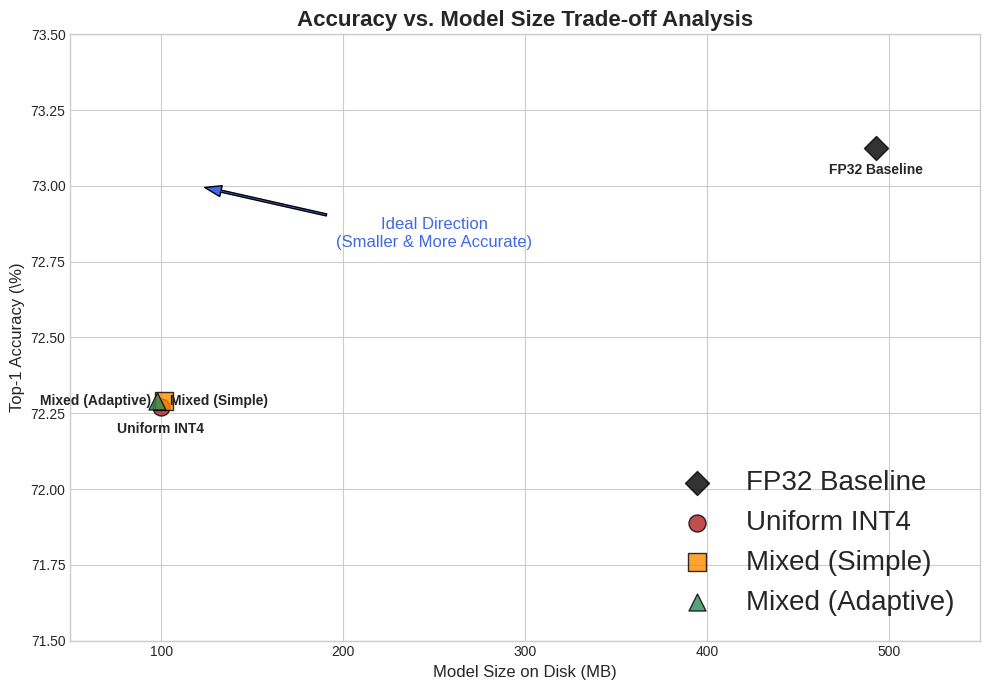

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


models_data = {
    'FP32 Baseline': {
        'accuracy': 73.125,
        'disk_size_mb': 492.96,
        'color': 'black',
        'marker': 'D',
        'marker_offset': (0, 0), 
        'text_align': {'ha': 'center', 'va': 'top'},
        'text_offset_padding': (0, -0.05)
    },
    'Uniform INT4': {
        'accuracy': 72.291,
        'disk_size_mb': 99.586,
        'color': 'firebrick',
        'marker': 'o',
        'marker_offset': (0, -0.02), 
        'text_align': {'ha': 'center', 'va': 'top'},
        'text_offset_padding': (0, -0.05) 
    },
    'Mixed (Simple)': {
        'accuracy': 72.291,
        'disk_size_mb': 99.586,
        'color': 'darkorange',
        'marker': 's',
        'marker_offset': (2.0, 0), 
        'text_align': {'ha': 'left', 'va': 'center'},
        'text_offset_padding': (3.0, 0) 
    },
    'Mixed (Adaptive)': {
        'accuracy': 72.291,
        'disk_size_mb': 99.586,
        'color': 'seagreen',
        'marker': '^',
        'marker_offset': (-2.0, 0), 
        'text_align': {'ha': 'right', 'va': 'center'},
        'text_offset_padding': (-3.0, 0) 
    }
}


plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))


for name, data in models_data.items():
  
    marker_x = data['disk_size_mb'] + data['marker_offset'][0]
    marker_y = data['accuracy'] + data['marker_offset'][1]

    ax.scatter(
        marker_x,
        marker_y,
        s=150,
        c=data['color'],
        marker=data['marker'],
        label=name,
        alpha=0.8,
        edgecolors='black'
    )


ax.set_title('Accuracy vs. Model Size Trade-off Analysis', fontsize=16, fontweight='bold')
ax.set_xlabel('Model Size on Disk (MB)', fontsize=12)
ax.set_ylabel('Top-1 Accuracy (\%)', fontsize=12)


for name, data in models_data.items():

    marker_x = data['disk_size_mb'] + data['marker_offset'][0]
    marker_y = data['accuracy'] + data['marker_offset'][1]

 
    text_x = marker_x + data['text_offset_padding'][0]
    text_y = marker_y + data['text_offset_padding'][1]

    ax.text(
        text_x,
        text_y,
        name,
        ha=data['text_align']['ha'],
        va=data['text_align']['va'],
        fontsize=10,
        fontweight='bold'
    )


ax.annotate(
    'Ideal Direction\n(Smaller & More Accurate)',
    xy=(120, 73.0),
    xytext=(250, 72.8),
    arrowprops=dict(facecolor='royalblue', shrink=0.05, width=1.5, headwidth=8),
    fontsize=12,
    ha='center',
    color='royalblue'
)


ax.set_xlim(left=50, right=550)
ax.set_ylim(bottom=71.5, top=73.5)


ax.legend(loc='lower right', fontsize=20)


output_filename = 'accuracy_vs_size_plot.png'
plt.tight_layout()
plt.savefig(output_filename, dpi=300)

print(f"Plot saved successfully as '{output_filename}'")

In [ ]:
import json
import time
from copy import deepcopy
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision.models import vgg11
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
from thop import profile

import torchao
from torchao.quantization import (
    quantize_,
    int8_weight_only,
    int4_weight_only,
    int8_dynamic_activation_int8_weight,
)

from torchao.dtypes import Int4CPULayout

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch._dynamo as dynamo
def test(model_to_test):
    model_to_test.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
           
            try:
                dtype = next(model_to_test.parameters()).dtype
                inputs = inputs.to(DEVICE, dtype=dtype)
            except StopIteration: 
                inputs = inputs.to(DEVICE)

            targets = targets.to(DEVICE)
            outputs = model_to_test(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

INFERENCE_BATCH_SIZE = 64
fp32_model = vgg11()
num_features = fp32_model.classifier[6].in_features
fp32_model.classifier[6] = nn.Linear(num_features, 100)
fp32_model = fp32_model.to(DEVICE)


if not os.path.exists("vgg16_cifar100_fp32.pth"):
    print("Weight file 'vgg16_cifar100_fp32.pth' not found. Using random weights.")
  
    torch.save(fp32_model.state_dict(), "vgg16_cifar100_fp32.pth")


state_dict = torch.load("vgg16_cifar100_fp32.pth", map_location="cpu")
fp32_model.load_state_dict(state_dict)
torch.set_float32_matmul_precision('high')

trainloader = DataLoader(trainset, batch_size=INFERENCE_BATCH_SIZE, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=INFERENCE_BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)

def get_model_size_mb(model_or_path):
    if isinstance(model_or_path, str):
        return os.path.getsize(model_or_path) / (1024*1024) if os.path.exists(model_or_path) else 0
    torch.save(model_or_path.state_dict(), "temp.p")
    size = os.path.getsize("temp.p") / (1024*1024)
    os.remove("temp.p")
    return size

def calculate_gmacs(model, device):
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
  
    macs, _ = profile(deepcopy(model), inputs=(dummy_input,), verbose=False)
    return macs / 1e9

def calculate_tbops(gmacs, w_bits, a_bits):
   
    return (gmacs * 1e9 * w_bits * a_bits * len(testloader.dataset)) / 1e12

def evaluate_performance(model, model_name="Model", compile_backend="inductor"):
    print(f"  - Evaluating {model_name} (Backend: {compile_backend})...")
    model.to(DEVICE).eval()

    @torch._dynamo.disable
    class EagerWrapper(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, *args, **kwargs):
            return self.module(*args, **kwargs)

  
    eval_model = deepcopy(model)
 
    if hasattr(eval_model, 'classifier') and isinstance(eval_model.classifier, nn.Sequential) and len(eval_model.classifier) > 0:
        eval_model.classifier[-1] = EagerWrapper(eval_model.classifier[-1])


    try:
        compiled_model = torch.compile(eval_model, backend=compile_backend, mode="max-autotune-no-cudagraphs")
    except Exception as e:
        print(f"    - torch.compile() with backend '{compile_backend}' failed, running uncompiled. Reason: {e}")
        compiled_model = eval_model

    print("  - Running warmup pass...")
    _ = test(compiled_model)

    if DEVICE == 'cuda':
        torch.cuda.synchronize(DEVICE)
        torch.cuda.reset_peak_memory_stats(DEVICE)

    start_time = time.time()
    accuracy = test(compiled_model)
    if DEVICE == 'cuda':
        torch.cuda.synchronize(DEVICE)
    end_time = time.time()

    inference_time = end_time - start_time
    vram = torch.cuda.max_memory_allocated(DEVICE) / (1024*1024) if DEVICE == 'cuda' else 0
    return accuracy, inference_time, vram

RESULTS_JSON_PATH = 'ptq_results_torchao_final.json'
MODEL_SAVE_DIR = 'saved_ptq_models_torchao'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

print("--- Starting PTQ Analysis with Official torchao API ---")

total_gmacs = calculate_gmacs(fp32_model, DEVICE)
fp32_tbops = calculate_tbops(total_gmacs, 32, 32)
print(f"--- Model Complexity (Hardware-Agnostic): {total_gmacs:.2f} GMACs per image ---")

print("\n[1/9] Evaluating baseline FP32 performance...")
fp32_accuracy, fp32_time, fp32_vram = evaluate_performance(fp32_model, "FP32", compile_backend="inductor")
fp32_disk_size = get_model_size_mb(fp32_model)
print(f"  - FP32 Results: Acc={fp32_accuracy:.2f}%, Time={fp32_time:.3f}s, VRAM={fp32_vram:.2f}MB, Size={fp32_disk_size:.2f}MB")

results = {'fp32': {'accuracy': fp32_accuracy, 'inference_time_sec': fp32_time, 'speedup_vs_fp32': 1.0, 'vram_footprint_mb': fp32_vram, 'disk_size_mb': fp32_disk_size, 'tbops': fp32_tbops}}

quantization_configs = {
    'fp16': {'type': 'dtype', 'dtype': torch.float16, 'backend': 'inductor', 'w_bits': 16, 'a_bits': 16},
    'bf16': {'type': 'dtype', 'dtype': torch.bfloat16, 'backend': 'inductor', 'w_bits': 16, 'a_bits': 16},
    'int4_weight_only': {'type': 'torchao', 'config': int4_weight_only(layout=Int4CPULayout()), 'calibrate': False, 'backend': 'inductor', 'w_bits': 4, 'a_bits': 16},
    'int8_dynamic': {'type': 'torchao', 'config': int8_dynamic_activation_int8_weight(), 'calibrate': False, 'backend': 'inductor', 'w_bits': 8, 'a_bits': 32},
    'int8_static_inductor': {'type': 'torchao', 'config': int8_dynamic_activation_int8_weight(), 'calibrate': True, 'backend': 'inductor', 'w_bits': 8, 'a_bits': 8},
    'int8_weight_only': {'type': 'torchao', 'config': int8_weight_only(), 'calibrate': False, 'backend': 'inductor', 'w_bits': 8, 'a_bits': 16},
    'int8_static_tensorrt': {'type': 'torchao', 'config': int8_dynamic_activation_int8_weight(), 'calibrate': True, 'backend': 'inductor', 'w_bits': 8, 'a_bits': 8},
  
    'simple_mixed_fp16_int4': {'type': 'custom_logic', 'backend': 'inductor', 'w_bits': 4, 'a_bits': 16},
    'variance_mixed_fp16_int4': {'type': 'custom_logic', 'backend': 'inductor', 'w_bits': 4, 'a_bits': 16},
}


num_quant_configs = len(quantization_configs)
for i, (name, config) in enumerate(quantization_configs.items()):
    print(f"\n[{i+2}/{num_quant_configs+1}] Applying and evaluating {name.upper()}...")
    model_to_quantize = deepcopy(fp32_model)
    try:
        if config['type'] == 'dtype':
            if config['dtype'] == torch.bfloat16 and not (torch.cuda.is_available() and torch.cuda.is_bf16_supported()):
                print("  - Skipping BF16, not supported on this device.")
                continue
            quantized_model = model_to_quantize.to(config['dtype'])

        elif config['type'] == 'torchao':
            quantize_(model_to_quantize, config['config'])
            if config['calibrate']:
                print("  - Calibrating for INT8 static quantization...")
                model_to_quantize.eval()
                with torch.no_grad():
                    for calib_idx, (data, _) in enumerate(trainloader):
                        if calib_idx >= 4:
                            break
                        model_to_quantize(data.to(DEVICE))
            quantized_model = model_to_quantize
            if name == 'int4_weight_only':
              
                quantized_model = quantized_model.to(torch.bfloat16)

    
        elif config['type'] == 'custom_logic':
           
            if name == 'simple_mixed_fp16_int4':
                print("  - Applying simple mixed precision (FP16 for all, INT4 for Linear layers)...")
              
                def linear_filter_fn(module, *args):
                    return isinstance(module, nn.Linear)
           
                quantize_(model_to_quantize, int4_weight_only(layout=Int4CPULayout()), filter_fn=linear_filter_fn)

              
                for module in model_to_quantize.modules():
                    if not isinstance(module, nn.Linear):
                        module.to(dtype=torch.float16)
                quantized_model = model_to_quantize

            elif name == 'variance_mixed_fp16_int4':
                print("  - Applying variance-based mixed precision (FP16 high-var, INT4 low-var)...")
                variances = {}
                for n, m in model_to_quantize.named_modules():
                    if hasattr(m, 'weight') and m.weight is not None:
                        variances[n] = torch.var(m.weight.data.float()).item()

                if not variances:
                     raise ValueError("Could not find any layers with weights to calculate variance.")

                threshold = np.median(list(variances.values()))
                print(f"  - Variance threshold (median): {threshold}")

                low_prec_modules = {n for n, v in variances.items() if v < threshold}

                def variance_filter_fn(module, fqn):
                    return fqn in low_prec_modules

                print(f"  - Quantizing {len(low_prec_modules)} layers to INT4...")
                quantize_(model_to_quantize, int4_weight_only(layout=Int4CPULayout()), filter_fn=variance_filter_fn)

                print("  - Converting high-variance layers to FP16...")
                for n, m in model_to_quantize.named_modules():
                    if n not in low_prec_modules:
                         m.to(dtype=torch.float16)

              
                quantized_model = model_to_quantize.to(torch.float16)

      
        if 'int4' in name:
            for p in quantized_model.parameters():
                if not p.is_contiguous():
                    p.data = p.contiguous()

        accuracy, infer_time, vram = evaluate_performance(quantized_model, name.upper(), compile_backend=config['backend'])
        speedup = fp32_time / infer_time
        model_path = os.path.join(MODEL_SAVE_DIR, f'{name}.pth')
        torch.save(quantized_model.state_dict(), model_path)
        disk_size = get_model_size_mb(model_path)

        tbops = calculate_tbops(total_gmacs, config['w_bits'], config['a_bits'])

        print(f"  - {name.upper()} Results: Acc={accuracy:.2f}%, Time={infer_time:.3f}s, VRAM={vram:.2f}MB, Size={disk_size:.2f}MB")
        print(f"  - Accuracy Drop: {fp32_accuracy - accuracy:.2f}% | Speed-up: {speedup:.2f}x | Theoretical Compute Reduction (BOPs): {(fp32_tbops / tbops if tbops > 0 else 0):.2f}x")
        results[name] = {'accuracy': accuracy, 'inference_time_sec': infer_time, 'speedup_vs_fp32': speedup, 'vram_footprint_mb': vram, 'disk_size_mb': disk_size, 'tbops': tbops}
    except Exception as e:
        print(f"  - Could not perform PTQ for {name}. Error: {e}")
        import traceback
        traceback.print_exc()
        results[name] = {'accuracy': 'Error', 'reason': str(e)}


with open(RESULTS_JSON_PATH, 'w') as f:
    json.dump(results, f, indent=4)
print(f"\n✅ PTQ analysis complete. Results saved to '{RESULTS_JSON_PATH}'")
print("\n--- Final Results Summary ---")
print(json.dumps(results, indent=4))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64 
NUM_FINETUNE_EPOCHS = 5
LEARNING_RATE = 0.001
BEST_MODEL_PATH = 'mobilenetv2_food101_fp32.pth'

print(f"Running on device: {DEVICE}")


print(f"\n--- Preparing Food-101 Dataset (will download if not present) ---")


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


trainset = torchvision.datasets.Food101(root='./data', split='train', download=True, transform=transform_train)
testset = torchvision.datasets.Food101(root='./data', split='test', download=True, transform=transform)


trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print("--- DataLoaders created successfully. ---")


print("\n--- Preparing MobileNetV2 for Fine-Tuning on Food-101 ---")


model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)


num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 101)
model = model.to(DEVICE)

print("Model architecture modified for Food-101:")
print(model.classifier)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
best_acc = 0

def train(epoch):
    
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
     
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch: {epoch+1} | Batch: {batch_idx+1}/{len(trainloader)} | Avg Loss: {running_loss/100:.3f}")
            running_loss = 0.0

def test():
   
    global best_acc
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(testloader):
            print(f"\rTesting batch {i+1}/{len(testloader)}", end="")
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print()
    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

  
    if accuracy > best_acc:
        print(f"Accuracy improved. Saving model to '{BEST_MODEL_PATH}'...")
        best_acc = accuracy
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    return accuracy

print(f"\n--- Starting FP32 Model Fine-Tuning for {NUM_FINETUNE_EPOCHS} epochs ---")
for epoch in range(NUM_FINETUNE_EPOCHS):
    train(epoch)
    test()

print(f"\n--- Fine-tuning complete. Best model saved at '{BEST_MODEL_PATH}' with accuracy: {best_acc:.2f}% ---")

In [ ]:
print(f"\n--- Preparing Food-101 Dataset (will download if not present) ---")


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


trainset = torchvision.datasets.Food101(root='./data', split='train', download=True, transform=transform_train)
testset = torchvision.datasets.Food101(root='./data', split='test', download=True, transform=transform)

# Create the DataLoaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
import json
import time
from copy import deepcopy
import os


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

import torchao
from torchao.quantization import (
    quantize_,
    int8_weight_only,
    int4_weight_only,
    int8_dynamic_activation_int8_weight,
)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch._dynamo as dynamo

def test(model_to_test):
    model_to_test.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
         
            try:
                dtype = next(model_to_test.parameters()).dtype
                inputs = inputs.to(DEVICE, dtype=dtype)
            except StopIteration:
                inputs = inputs.to(DEVICE)

            targets = targets.to(DEVICE)
            outputs = model_to_test(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

INFERENCE_BATCH_SIZE = 64
fp32_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)


num_features = fp32_model.classifier[1].in_features
fp32_model.classifier[1] = nn.Linear(num_features, 101)
fp32_model = fp32_model.to(DEVICE)

state_dict = torch.load("mobilenetv2_food101_fp32.pth", map_location="cpu")
fp32_model.load_state_dict(state_dict)
torch.set_float32_matmul_precision('high')

trainloader = DataLoader(trainset, batch_size=INFERENCE_BATCH_SIZE, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=INFERENCE_BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)

def get_model_size_mb(model_or_path):
    if isinstance(model_or_path, str):
        return os.path.getsize(model_or_path) / (1024*1024) if os.path.exists(model_or_path) else 0
    torch.save(model_or_path.state_dict(), "temp.p")
    size = os.path.getsize("temp.p") / (1024*1024)
    os.remove("temp.p")
    return size

def calculate_gmacs(model, device):
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
  
    macs, _ = profile(deepcopy(model), inputs=(dummy_input,), verbose=False)
    return macs / 1e9

def calculate_tbops(gmacs, w_bits, a_bits):
 
    return (gmacs * 1e9 * w_bits * a_bits * len(testloader.dataset)) / 1e12

def evaluate_performance(model, model_name="Model", compile_backend="inductor"):
    print(f"  - Evaluating {model_name} (Backend: {compile_backend})...")
    model.to(DEVICE).eval()

    @torch._dynamo.disable
    class EagerWrapper(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, *args, **kwargs):
            return self.module(*args, **kwargs)

   
    eval_model = deepcopy(model)
    eval_model.classifier[-1] = EagerWrapper(eval_model.classifier[-1])

    try:
        compiled_model = torch.compile(eval_model, backend=compile_backend, mode="max-autotune-no-cudagraphs")
    except Exception as e:
        print(f"    - torch.compile() with backend '{compile_backend}' failed, running uncompiled. Reason: {e}")
        compiled_model = eval_model

    print("  - Running warmup pass...")
    _ = test(compiled_model)

    if DEVICE == 'cuda':
        torch.cuda.synchronize(DEVICE)
        torch.cuda.reset_peak_memory_stats(DEVICE)

    start_time = time.time()
    accuracy = test(compiled_model)
    if DEVICE == 'cuda':
        torch.cuda.synchronize(DEVICE)
    end_time = time.time()

    inference_time = end_time - start_time
    vram = torch.cuda.max_memory_allocated(DEVICE) / (1024*1024) if DEVICE == 'cuda' else 0
    return accuracy, inference_time, vram

RESULTS_JSON_PATH = 'ptq_results_mobilenet_torchao_final.json'
MODEL_SAVE_DIR = 'saved_ptq_models_torchao_mobilenet'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

print("--- Starting PTQ Analysis with Official torchao API ---")

total_gmacs = calculate_gmacs(fp32_model, DEVICE)
fp32_tbops = calculate_tbops(total_gmacs, 32, 32)
print(f"--- Model Complexity (Hardware-Agnostic): {total_gmacs:.2f} GMACs per image ---")

print("\n[1/7] Evaluating baseline FP32 performance...")
fp32_accuracy, fp32_time, fp32_vram = evaluate_performance(fp32_model, "FP32", compile_backend="inductor")
fp32_disk_size = get_model_size_mb(fp32_model)
print(f"  - FP32 Results: Acc={fp32_accuracy:.2f}%, Time={fp32_time:.3f}s, VRAM={fp32_vram:.2f}MB, Size={fp32_disk_size:.2f}MB")

results = {'fp32': {'accuracy': fp32_accuracy, 'inference_time_sec': fp32_time, 'speedup_vs_fp32': 1.0, 'vram_footprint_mb': fp32_vram, 'disk_size_mb': fp32_disk_size, 'tbops': fp32_tbops}}

quantization_configs = {
    'fp16': {'type': 'dtype', 'dtype': torch.float16, 'backend': 'inductor', 'w_bits': 16, 'a_bits': 16},
    'bf16': {'type': 'dtype', 'dtype': torch.bfloat16, 'backend': 'inductor', 'w_bits': 16, 'a_bits': 16},
    'int4_weight_only': {'type': 'torchao', 'config': int4_weight_only(), 'calibrate': False, 'backend': 'inductor', 'w_bits': 4, 'a_bits': 16},
    'int8_dynamic': {'type': 'torchao', 'config': int8_dynamic_activation_int8_weight(), 'calibrate': False, 'backend': 'inductor', 'w_bits': 8, 'a_bits': 32},
    'int8_static_inductor': {'type': 'torchao', 'config': int8_dynamic_activation_int8_weight(), 'calibrate': True, 'backend': 'inductor', 'w_bits': 8, 'a_bits': 8},
    'int8_weight_only': {'type': 'torchao', 'config': int8_weight_only(), 'calibrate': False, 'backend': 'inductor', 'w_bits': 8, 'a_bits': 16},
    'int8_static_tensorrt': {'type': 'torchao', 'config': int8_dynamic_activation_int8_weight(), 'calibrate': True, 'backend': 'inductor', 'w_bits': 8, 'a_bits': 8},
}

num_quant_configs = len(quantization_configs)
for i, (name, config) in enumerate(quantization_configs.items()):
    print(f"\n[{i+2}/{num_quant_configs+1}] Applying and evaluating {name.upper()}...")
    model_to_quantize = deepcopy(fp32_model)
    try:
        if config['type'] == 'dtype':
            if config['dtype'] == torch.bfloat16 and not (torch.cuda.is_available() and torch.cuda.is_bf16_supported()):
                print("  - Skipping BF16, not supported on this device.")
                continue
            quantized_model = model_to_quantize.to(config['dtype'])
        elif config['type'] == 'torchao':
            quantize_(model_to_quantize, config['config'])
            if config['calibrate']:
                print("  - Calibrating for INT8 static quantization...")
                model_to_quantize.eval()
                with torch.no_grad():
                    for calib_idx, (data, _) in enumerate(trainloader):
                        if calib_idx >= 4:
                            break
                        model_to_quantize(data.to(DEVICE))
            quantized_model = model_to_quantize
            if name == 'int4_weight_only':
                quantized_model = quantized_model.to(torch.bfloat16)
                for p in quantized_model.parameters():
                    if not p.is_contiguous():
                        p.data = p.contiguous()

        accuracy, infer_time, vram = evaluate_performance(quantized_model, name.upper(), compile_backend=config['backend'])
        speedup = fp32_time / infer_time
        model_path = os.path.join(MODEL_SAVE_DIR, f'{name}.pth')
        torch.save(quantized_model.state_dict(), model_path)
        disk_size = get_model_size_mb(model_path)

        tbops = calculate_tbops(total_gmacs, config['w_bits'], config['a_bits'])

        print(f"  - {name.upper()} Results: Acc={accuracy:.2f}%, Time={infer_time:.3f}s, VRAM={vram:.2f}MB, Size={disk_size:.2f}MB")
        print(f"  - Accuracy Drop: {fp32_accuracy - accuracy:.2f}% | Speed-up: {speedup:.2f}x | Theoretical Compute Reduction (BOPs): {(fp32_tbops / tbops):.2f}x")
        results[name] = {'accuracy': accuracy, 'inference_time_sec': infer_time, 'speedup_vs_fp32': speedup, 'vram_footprint_mb': vram, 'disk_size_mb': disk_size, 'tbops': tbops}
    except Exception as e:
        print(f"  - Could not perform PTQ for {name}. Error: {e}")
        results[name] = {'accuracy': 'Error', 'reason': str(e)}

with open(RESULTS_JSON_PATH, 'w') as f:
    json.dump(results, f, indent=4)
print(f"\n✅ PTQ analysis complete. Results saved to '{RESULTS_JSON_PATH}'")
print("\n--- Final Results Summary ---")
print(json.dumps(results, indent=4))

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import vgg11
from copy import deepcopy
import warnings
import json


from torch.ao.quantization import get_default_qat_qconfig, prepare_qat, convert


from torch.cuda.amp import GradScaler, autocast


warnings.filterwarnings("ignore", category=UserWarning)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
INFERENCE_BATCH_SIZE = 64
TRAIN_BATCH_SIZE = 64
FINETUNE_EPOCHS = 2
LEARNING_RATE = 1e-5
RESULTS_JSON_PATH = 'qat_finetune_results.json'
MODEL_SAVE_DIR = 'saved_qat_models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)



trainloader = DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=INFERENCE_BATCH_SIZE, shuffle=False, num_workers=4)

print(f"--- Loading pre-trained FP32 VGG11 model on {DEVICE} ---")
fp32_model = vgg11()
num_features = fp32_model.classifier[6].in_features
fp32_model.classifier[6] = nn.Linear(num_features, 100)
state_dict = torch.load("vgg16_cifar100_fp32.pth", map_location="cpu")
fp32_model.load_state_dict(state_dict)
fp32_model.to(DEVICE)
torch.set_float32_matmul_precision('high')

def test_accuracy(model, data_loader, device):
  
    model.eval()
    correct = 0
    total = 0
    model_dtype = next(model.parameters()).dtype
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.to(model_dtype)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    return accuracy


quantization_configs = {
    'int8_static_qat': {'type': 'torch_qat'},
    'fp16_finetune': {'type': 'dtype', 'dtype': torch.float16},
    'bf16_finetune': {'type': 'dtype', 'dtype': torch.bfloat16},
}


results = {}


for name, config in quantization_configs.items():
    print(f"\n{'='*50}\n--- Starting procedure for: {name.upper()} ---\n{'='*50}")


    model_to_finetune = deepcopy(fp32_model)

    if config['type'] == 'torch_qat':
        print(f"  - [Step 1/3] Preparing model for INT8 QAT using torch.ao API...")
        qconfig = get_default_qat_qconfig('fbgemm')
        model_to_finetune.train()
        prepare_qat(model_to_finetune, inplace=True)

    elif config['type'] == 'dtype':
        if config['dtype'] == torch.bfloat16 and not (torch.cuda.is_available() and torch.cuda.is_bf16_supported()):
            print("  - Skipping BF16, not supported on this device.")
            continue
        target_dtype = config['dtype']
        print(f"  - [Step 1/3] Casting model to {target_dtype} for fine-tuning...")
        model_to_finetune.to(target_dtype)

    print(f"  - [Step 2/3] Fine-tuning model for {FINETUNE_EPOCHS} epochs...")
    optimizer = torch.optim.AdamW(model_to_finetune.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()


    use_fp16 = config.get('dtype') == torch.float16
    scaler = GradScaler(enabled=use_fp16)

    initial_acc = test_accuracy(model_to_finetune, testloader, DEVICE)
    print(f"  - Accuracy before fine-tuning: {initial_acc:.2f}%")

    model_dtype = next(model_to_finetune.parameters()).dtype
    for epoch in range(FINETUNE_EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{FINETUNE_EPOCHS} ---")
        model_to_finetune.train()
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            inputs = inputs.to(model_dtype)
            optimizer.zero_grad()

            with autocast(enabled=use_fp16):
                outputs = model_to_finetune(inputs)
                loss = criterion(outputs, targets)

      
            scaler.scale(loss).backward()
         
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                print(f'    - Step [{i + 1}/{len(trainloader)}], Avg Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

        epoch_accuracy = test_accuracy(model_to_finetune, testloader, DEVICE)
        print(f"  - ✅ Accuracy after Epoch {epoch + 1}: {epoch_accuracy:.2f}%")

    final_model = model_to_finetune
    if config['type'] == 'torch_qat':
        print("\n  - [Step 3/3] Converting fine-tuned model to a final deployable INT8 model...")
        final_model.eval()
        convert(final_model, inplace=True)
    else:
        print("\n  - [Step 3/3] Fine-tuning complete. Model is already in its final format.")

    final_accuracy = test_accuracy(final_model, testloader, DEVICE)
    print(f"\n--- Procedure for {name.upper()} Complete ---")
    print(f"  - Final Model Accuracy: {final_accuracy:.2f}%")

    model_path = os.path.join(MODEL_SAVE_DIR, f'{name}.pth')
    torch.save(final_model.state_dict(), model_path)
    print(f"  - Final model saved to: '{model_path}'")

    results[name] = {'final_accuracy': final_accuracy}



with open(RESULTS_JSON_PATH, 'w') as f:
    json.dump(results, f, indent=4)
print(f"\n✅ QAT/Fine-tuning analysis complete. Results saved to '{RESULTS_JSON_PATH}'")
print("\n--- Final Results Summary ---")
print(json.dumps(results, indent=4))

In [ ]:
import torch
import subprocess
import sys
import platform

def run_command(command):

    try:
        output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT, universal_newlines=True)
        return output.strip()
    except subprocess.CalledProcessError as e:
        return f"Error: {e.output.strip()}"

def check_gpu_and_cuda():

    print("─" * 80)
    print(" " * 30 + "GPU and CUDA Check")
    print("─" * 80)


    print("1. Checking for NVIDIA GPU and drivers...")
    try:
        nvidia_smi_output = subprocess.check_output('nvidia-smi', shell=True, universal_newlines=True)
        print("   NVIDIA GPU and drivers detected.")
        print(nvidia_smi_output)
    except Exception:
        print("   No NVIDIA GPU detected or 'nvidia-smi' command not found.")
        print("   Ensure NVIDIA drivers are installed and in your system's PATH.")
        return

    
    print("\n2. Checking PyTorch and CUDA availability...")
    if torch.cuda.is_available():
        print("   PyTorch can access CUDA.")
        print(f"   - PyTorch version: {torch.__version__}")
        print(f"   - CUDA version PyTorch was compiled with: {torch.version.cuda}")
        print(f"   - Number of available GPUs: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"     - GPU {i}: {torch.cuda.get_device_name(i)}")
            props = torch.cuda.get_device_properties(i)
            print(f"       - Compute Capability: {props.major}.{props.minor}")
            print(f"       - Total Memory: {props.total_memory / 1024**3:.2f} GB")
        print(f"   - cuDNN version: {torch.backends.cudnn.version()}")
    else:
        print("   PyTorch cannot access CUDA.")
        print("   Possible reasons:")
        print("     - You installed the CPU-only version of PyTorch.")
        print("     - Your NVIDIA driver version is not compatible with your CUDA version.")
        print("     - The CUDA toolkit is not installed or not in the system's PATH.")

def check_ffmpeg():
  
    print("\n" + "─" * 80)
    print(" " * 33 + "FFmpeg Check")
    print("─" * 80)
    try:
        ffmpeg_version = run_command("ffmpeg -version")
        if "ffmpeg version" in ffmpeg_version:
            print("FFmpeg is installed and accessible in the system's PATH.")
            print(ffmpeg_version.splitlines()[0])
        else:
            print("FFmpeg command exists but might not be the correct executable.")
            print(f"Output: {ffmpeg_version}")
    except Exception:
        print("FFmpeg is not found in the system's PATH.")
        print("Please install FFmpeg and ensure its location is in your system's PATH environment variable.")
        print("Note: 'pip install ffmpeg' or 'pip install ffmpeg-python' installs a Python wrapper, not the FFmpeg executable itself.")


def check_cutlass_initialization_issues():
  
    print("\n" + "─" * 80)
    print(" " * 20 + "Troubleshooting CUTLASS Initialization")
    print("─" * 80)
    print("CUTLASS is a high-performance deep learning library from NVIDIA. If you are facing initialization issues,")
    print("it's often related to the underlying CUDA environment and how your deep learning framework is configured.")
    print("\nCommon reasons for CUTLASS initialization failure:")
    print("1.  **Incompatible CUDA and Driver Versions:** CUTLASS relies on a specific CUDA toolkit version.")
    print("    Ensure that your NVIDIA driver is compatible with the CUDA toolkit version required by your")
    print("    deep learning framework and its CUTLASS backend.")
    print("\n2.  **PyTorch Installed Without CUDA Support:** If you are using PyTorch, it must be installed with")
    print("    CUDA support. A CPU-only build of PyTorch will not be able to initialize CUDA-based libraries")
    print("    like CUTLASS.")
    print("\n3.  **CUDA Context Not Initialized:** Sometimes, the CUDA context within your application might not")
    print("    be properly initialized before CUTLASS functions are called. This can be an issue within the")
    print("    framework you are using.")
    print("\n4.  **Environment Variable Issues:** Important environment variables like `CUDA_HOME` might not be set")
    print("    correctly, preventing the system from finding the necessary CUDA libraries.")
    print("\n5.  **Issues with the Framework Using CUTLASS:** The problem might not be with your environment but with")
    print("    the specific library or application that depends on CUTLASS. There could be a bug or a")
    print("    misconfiguration in that software.")
    print("\nTo diagnose further, you would typically need to look at the specific error messages and the context")
    print("in which the initialization fails.")


if __name__ == "__main__":
    print("Starting system check for GPU, CUDA, PyTorch, and FFmpeg...")
    print(f"Python version: {sys.version}")
    print(f"Platform: {platform.platform()}")
    check_gpu_and_cuda()
    check_ffmpeg()
    check_cutlass_initialization_issues()
    print("\nSystem check finished.")